In [830]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import random
import time
import tensorflow.compat.v2 as tf

from sklearn.utils import shuffle

from collections import Counter 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense

In [831]:
data = pd.read_csv('train_jan06_task4bonus.csv')
pred = pd.read_csv('test_jan06_task4bonus.csv')


In [832]:
# handle na data with medium

for i in data.columns:
    if data[i].isnull().sum() > 0:
        data[i].fillna((data[i].median()), inplace=True)

data.isnull().sum()

for i in pred.columns:
    if pred[i].isnull().sum() > 0:
        pred[i].fillna((pred[i].median()), inplace=True)

pred.isnull().sum()


feature0     0
feature1     0
feature2     0
feature3     0
feature4     0
feature5     0
feature6     0
feature7     0
feature8     0
feature9     0
feature10    0
feature11    0
feature12    0
feature13    0
dtype: int64

In [833]:
l_encode = LabelEncoder()
l_encode.fit(data['class'])
Y = l_encode.transform(data['class'])
Y = to_categorical(Y)
Y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [834]:
Counter(data['class'])

Counter({'A': 1000, 'B': 2000, 'C': 2500, 'D': 1000})

In [835]:
# split train and test data
X = data.drop(['class'], axis=1)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 0)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((5200, 14), (5200, 4), (1300, 14), (1300, 4))

In [836]:
# # use SMOTE to balance the data
# from imblearn.over_sampling import SMOTE
# train_x, train_y = SMOTE(random_state=42, sampling_strategy={[1, 0, 0, 0]: 0., 'B': 70, 'C': 90, 'D': 40}).fit_resample(train_x, train_y)

# # check the imbalance of the data again
# # print(f"Testing target statistics: {Counter(train_y)}")
# train_x.shape
# train_y.shape

In [837]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)
pred = scaler.transform(pred)

In [838]:
in_dim = len(data.columns)-1
model = Sequential()

model.add(Dense(16, input_dim = in_dim, activation = 'sigmoid'))
model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(12, activation = 'sigmoid'))
model.add(tf.keras.layers.Dropout(0.05))

model.add(Dense(8, activation = 'sigmoid'))

model.add(Dense(4, activation = 'softmax'))

In [839]:
lr = np.arange(0.0006, 0.001, 0.0001)
for i in lr:
    print(i)

0.0006
0.0007
0.0008
0.0009000000000000001
0.001


In [840]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

best_model = None
best_score = 0

lr = np.arange(0.0006, 0.001, 0.0001)
for i in lr:
    print(f"lr: {i}")
    optimizers = [tf.keras.optimizers.Adam(learning_rate=i), tf.keras.optimizers.Adadelta(learning_rate=i), tf.keras.optimizers.Adagrad(learning_rate=i), tf.keras.optimizers.RMSprop(learning_rate=i), tf.keras.optimizers.SGD(learning_rate=i)]

    for j in optimizers:
        print(f"optimizer: {j}")
        model.compile(loss = 'categorical_crossentropy', optimizer=j, metrics = ['accuracy'])
        hist = model.fit(train_x, train_y, epochs = 400, batch_size = 32, validation_split=0.2, verbose=0, callbacks=[callback])
        scores = model.evaluate(test_x, test_y)

        # save the best model depending on the accuracy
        if scores[1] > best_score:
            print(f"best score: {scores[1]}")
            print(f"lr: {i}, optimizer: {j}")
            best_model = model
            best_score = scores[1]


        
           





# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)
# model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])
# hist = model.fit(train_x, train_y, epochs = 1000, batch_size = 32, validation_split=0.2, callbacks=[callback], verbose=0)
# # hist = model.fit(train_x, train_y, epochs = 400, batch_size = 32, validation_split=0.2)
# scores = model.evaluate(test_x, test_y)

# for i, m in enumerate(model.metrics_names):
#     print("\n%s: %.3f"% (m, scores[i]))

lr: 0.0006
optimizer: <keras.optimizers.optimizer_experimental.adam.Adam object at 0x0000020B9979D520>
41/41 [==============================] - 0s 775us/step - loss: 1.3311 - accuracy: 0.3069
best score: 0.3069230914115906
lr: 0.0006, optimizer: <keras.optimizers.optimizer_experimental.adam.Adam object at 0x0000020B9979D520>
optimizer: <keras.optimizers.optimizer_experimental.adadelta.Adadelta object at 0x0000020BAAC3A580>
41/41 [==============================] - 0s 750us/step - loss: 1.3221 - accuracy: 0.3069
optimizer: <keras.optimizers.optimizer_experimental.adagrad.Adagrad object at 0x0000020BAAC3A520>
41/41 [==============================] - 0s 800us/step - loss: 1.3055 - accuracy: 0.3069
optimizer: <keras.optimizers.optimizer_experimental.rmsprop.RMSprop object at 0x0000020B8227DEE0>
41/41 [==============================] - 0s 900us/step - loss: 1.2115 - accuracy: 0.5069
best score: 0.5069230794906616
lr: 0.0006, optimizer: <keras.optimizers.optimizer_experimental.rmsprop.RMSprop

In [829]:
# check best model
scores = best_model.evaluate(test_x, test_y)
for i, m in enumerate(best_model.metrics_names):
    print("\n%s: %.3f"% (m, scores[i]))

41/41 [==============================] - 0s 875us/step - loss: 0.7025 - accuracy: 0.7231

loss: 0.702

accuracy: 0.723


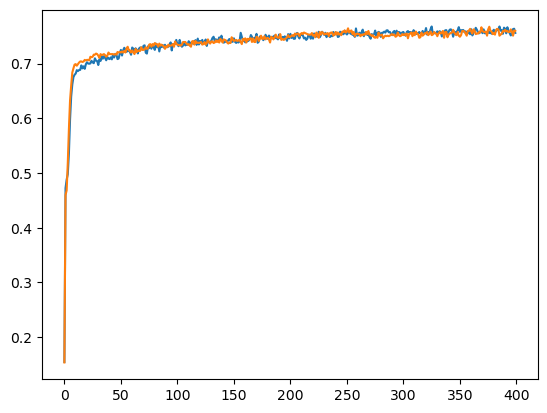

In [793]:
# plot the model accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.show()

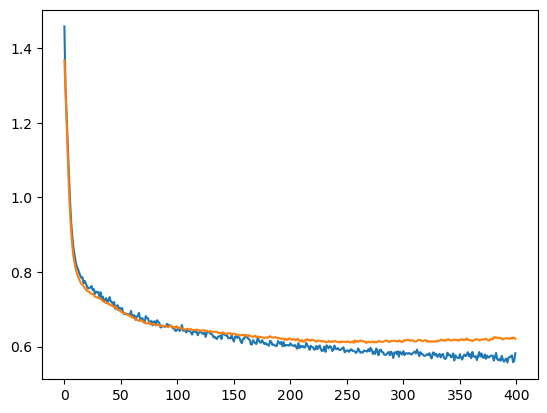

In [794]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [795]:
print("Generate a prediction")
prediction = model.predict(pred)
print("prediction shape:", prediction.shape)

Generate a prediction
50/50 [==============================] - 0s 1ms/step
prediction shape: (1600, 4)


In [796]:
prediction

array([[6.2853057e-04, 6.3655391e-02, 9.2977887e-01, 5.9371698e-03],
       [8.6421510e-03, 9.2092001e-01, 6.7280799e-02, 3.1570580e-03],
       [4.3577859e-03, 5.7302946e-01, 4.1686097e-01, 5.7517155e-03],
       ...,
       [5.1849231e-02, 5.4586557e-04, 6.3355193e-03, 9.4126940e-01],
       [3.8721226e-02, 2.2689172e-03, 2.1558042e-01, 7.4342942e-01],
       [9.4945193e-04, 3.6790166e-02, 9.5910692e-01, 3.1535192e-03]],
      dtype=float32)

In [797]:
pred_ = l_encode.inverse_transform(prediction.argmax(axis=1))

In [798]:
pred_

array(['C', 'B', 'B', ..., 'D', 'D', 'C'], dtype=object)

In [799]:
da = {"Id": [x for x in range(1, len(pred_)+1)], "Category": pred_}
df = pd.DataFrame (da)

In [782]:
df.to_csv("output.csv", index=False)